# Import all the packages used

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import vampnet
import gc

print(tf.__version__)
from vampnet import data_generator as vamp_data_generator
from tensorflow.contrib.keras.api.keras.models import Model
from tensorflow.contrib.keras.api.keras.layers import Dense, Activation, Flatten, Input, BatchNormalization, concatenate
from tensorflow.contrib.keras.api.keras.optimizers import Adam

import matplotlib.gridspec as gridspec
from tensorflow.contrib.keras.api.keras.backend import clear_session

plt.rcParams["figure.figsize"] = (20,6)

1.15.0


# Define Hyperparameters

In [2]:
# Tau, how much is the timeshift of the two datasets
tau = 1

# Batch size for Stochastic Gradient descent
batch_size = 256 #1000

# Which trajectory points percentage is used as training
train_ratio = 0.9

# How many hidden layers the network has
network_depth = 10 #10, 5

# Width of first layer
layer_width = 10 #50, 500

# Width of succeeding layers relative to previous
layer_width_decrease_factor = 1 #1, 2/3

# Learning rate used for the ADAM optimizer
learning_rate = 1e-3 #1e-4

# How many output states the network has
output_size = 2

dump_period=1000
picoseconds_per_step = 0.01  * dump_period # ps

peptide_atoms = 176 # how many particles in 1 peptide?

# Iteration over the training set in the fitting process
nb_epoch = 20 #10

model_name = "gaurav_03_07"

epsilon = 1e-5

# Get train data

In [3]:
from os import walk

path_to_raw_coords = "processed/coords/"

coords_files = []
for (dirpath, dirnames, filenames) in walk(path_to_raw_coords):
    coords_files.extend(filenames)
    break
    
coords_files = [coords_files[1]]
coords_files

['10us_prod_a08_onlyprot.npy']

In [4]:
raw_coords_test = np.load(path_to_raw_coords + '10us_prod_a08_onlyprot.npy')

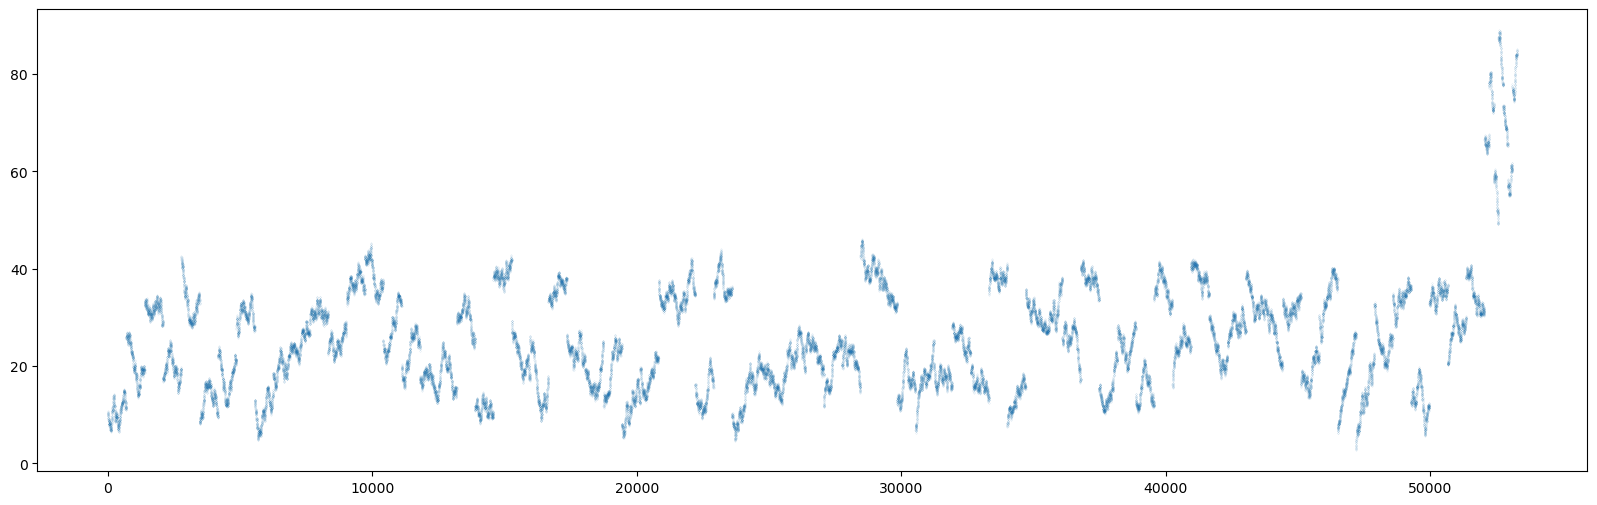

In [5]:
test_frame = 0
plt.plot(raw_coords_test[test_frame, :, -1], '.', markersize = .1)

In [55]:
concatenation_points = np.array([], dtype=np.uint32)
count_files = 0
for file_name in coords_files:
    file_snapshots_amount = np.load(path_to_raw_coords + file_name).shape[0]
    if(count_files > 0):
        concatenation_points = np.append(concatenation_points, file_snapshots_amount + concatenation_points[count_files - 1])
    else:
        concatenation_points = np.append(concatenation_points, file_snapshots_amount)
    count_files += 1

concatenation_points -= 1    # get indexes
concatenation_points = np.delete(concatenation_points, -1)

raw_coords = np.load(path_to_raw_coords + "10us_prod_a08_onlyprot.npy") #np.concatenate( [np.load(path_to_raw_coords + coords_files[i]) for i in range(len(coords_files))] )

concatenation_points = np.array([])

snapshots = raw_coords.shape[0]
atoms = raw_coords.shape[1]

raw_coords -= np.average(raw_coords, axis = 1).reshape(snapshots, 1, 3)  #mean-free cordinates

raw_z_coords = raw_coords[:, :, 2::3].reshape(snapshots, atoms)

print(raw_z_coords.shape)
#plt.plot(raw_z_coords[-1], '.', markersize=1.5);

(942, 53282)


In [7]:
peptides_total_amount = 7
peptides_amount = 1 #7

peptide_coords = raw_coords[:, -peptide_atoms * peptides_amount:, :].reshape(
    snapshots, peptides_amount * peptide_atoms, 3);
for peptide_idx in range(1, peptides_total_amount):
    new_peptide_coords = raw_coords[:, -(peptide_idx+1)*peptide_atoms * peptides_amount:-(peptide_idx)*peptide_atoms * peptides_amount, :]    
    new_peptide_coords = new_peptide_coords.reshape(snapshots, peptides_amount * peptide_atoms, 3)
    
    
    peptide_coords = np.append(peptide_coords, new_peptide_coords, axis = 0)
    concatenation_points = np.append(concatenation_points, peptide_idx * peptide_atoms)

peptide_coords = np.abs(peptide_coords)

In [8]:
gc.collect()

max_peptide_coord = np.max(np.abs(peptide_coords.reshape(snapshots * 7, peptide_atoms, 3)), axis = 0)

peptide_coords/= max_peptide_coord

In [9]:
# calculates subset of pairwise distances so that whole point cloud is reconstructable
# 4+ pairwise_dists_per_vertex guarantees reconstructability in 3D
def compute_pairwise_distances(data, n_pairwise_dists_per_vertex=4, delta=None):
    frames, particles, coord_features = data.shape

    if delta is None:
        delta = particles // 10

    indices = np.arange(particles)
    indices_shifted = np.mod(indices[:, np.newaxis] + np.arange(1, n_pairwise_dists_per_vertex + 1) * delta, particles)

    pairwise_diff = data[:, indices_shifted, :] - data[:, indices, np.newaxis, :]
    pairwise_distances = np.linalg.norm(pairwise_diff, axis=3)

    return pairwise_distances

def delay_embedding_trajectory(data, embedding):
    frames = data.shape[0]
    n_features = np.prod(data.shape[1:])

    # Calculate the number of delay embedding samples
    num_samples = frames - (embedding - 1)

    # Create an array of indices for advanced indexing
    indices = np.arange(embedding) + np.arange(num_samples)[:, np.newaxis]

    # Use advanced indexing to get the delay embedding trajectory
    trajectory = data[indices].reshape(num_samples, n_features * embedding)

    return trajectory

In [10]:
traj_whole =  delay_embedding_trajectory(peptide_coords, embedding=1)
traj_data_points = traj_whole.shape[0]
traj_whole = traj_whole.reshape((traj_data_points, -1))

traj_data_points, input_size = traj_whole.shape

# Initialized the VAMPnets wrapper class

In [11]:
vamp = vampnet.VampnetTools(epsilon = epsilon)

# Shuffle trajectory and lagged trajectory together

In [12]:
length_data = traj_data_points - tau

traj_ord = traj_whole[:length_data, ...]
traj_ord_lag = traj_whole[tau:length_data+tau, ...]

if(concatenation_points.size > 0): 
    traj_ord = np.delete(traj_ord, concatenation_points.astype(np.int), axis = 0)
    traj_ord_lag = np.delete(traj_ord_lag, concatenation_points.astype(np.int), axis = 0)

length_data -= concatenation_points.size

indexes = np.arange(length_data)
np.random.shuffle(indexes)

traj = traj_ord[indexes]
traj_lag = traj_ord_lag[indexes]

/uni-mainz.de/homes/tuchkovy/miniconda3/envs/tfenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys
/uni-mainz.de/homes/tuchkovy/miniconda3/envs/tfenv/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish t

# Prepare data for tensorflow usage

In [13]:
length_train = int(np.floor(length_data * train_ratio))
length_vali = length_data - length_train

traj_data_train = traj[:length_train]
traj_data_train_lag = traj_lag[:length_train]

traj_data_valid = traj[length_train:]
traj_data_valid_lag = traj_lag[length_train:]

# Input of the first network
X1_train = traj_data_train.astype('float32')
X2_train  = traj_data_train_lag.astype('float32')

# Input for validation
X1_vali = traj_data_valid.astype('float32')
X2_vali = traj_data_valid_lag.astype('float32')

# Needs a Y-train set which we dont have.
Y_train = np.zeros((length_train,2*output_size)).astype('float32')
Y_vali = np.zeros((length_vali,2*output_size)).astype('float32')

In [14]:
graph = tf.Graph()
def build_model():
    nodes =  [layer_width * (layer_width_decrease_factor ** i) for i in range(network_depth)] #[layer_width]*network_depth

    Data_X = Input(shape = (input_size,))
    Data_Y = Input(shape = (input_size,))

    # A batch normalization layer improves convergence speed
    bn_layer = BatchNormalization()

    # Instance layers and assign them to the two lobes of the network
    dense_layers = [Dense(node, activation = 'tanh')# if index_layer < 3 else 'linear nodes')
                    for index_layer,node in enumerate(nodes)]

    lx_branch = bn_layer(Data_X)
    rx_branch = bn_layer(Data_Y)

    for i, layer in enumerate(dense_layers):

        lx_branch = dense_layers[i](lx_branch)
        rx_branch = dense_layers[i](rx_branch)


    # Add a softmax output layer.
    # Should be replaced with a linear activation layer if
    # the outputs of the network cannot be interpreted as states
    softmax = Dense(output_size, activation='softmax')

    lx_branch = softmax(lx_branch)
    rx_branch = softmax(rx_branch)

    # Merge both networks to train both at the same time
    merged = concatenate([lx_branch, rx_branch])

    # Initialize the model and the optimizer, and compile it with
    # the loss and metric functions from the VAMPnets package
    model = Model(inputs = [Data_X, Data_Y], outputs = merged)
    adam = Adam(lr = learning_rate/10)
    return model, adam

model, adam = build_model()
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 528)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 528)]        0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 528)          2112        input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)

# Enable GPU if possible

In [80]:
#from tensorflow.python.client import device_lib 
#with tf.device(tf.DeviceSpec(device_type="GPU", device_index=gpu_id)):
#    print("GPU")
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Run several model iterations saving the best one, to help finding sparcely populated states

In [81]:
checkpoint_path = "model_checkpoints/"

my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=2)
]

max_vm = 0
attempts = 3 #10
found_better_weights = 0

# IMPORTANT: the function vamp.loss_VAMP2_autograd can only be used with tensorflow 1.6 or more recent.
# For older versions of TF, use the function vamp.loss_VAMP2

losses = [
          vamp.loss_VAMP2_autograd,
]

# Set the graph as the default graph
tf.keras.backend.set_session(tf.Session(graph=graph))
for i in range(attempts):    
    print("Attempt", i)
    # Clear the previous tensorflow session to prevent memory leaks
    clear_session()

    # Build the model
    model, adam = build_model()

    vm1 = np.zeros((len(losses), nb_epoch))
    tm1 = np.zeros_like(vm1)
    vm2 = np.zeros_like(vm1)
    tm2 = np.zeros_like(vm1)
    vm3 = np.zeros_like(vm1)
    tm3 = np.zeros_like(vm1)
    valid_metric = np.zeros_like(vm1)
    train_metric = np.zeros_like(vm1)

    for l_index, loss_function in enumerate(losses):
        
        model.compile(optimizer = adam,
                      loss = loss_function,
                      metrics = [
                          vamp.metric_VAMP,
                          vamp.metric_VAMP2,
                                 ])
        
        # Train the model
        print("Started training model.")        
        hist = model.fit([X1_train, X2_train], Y_train ,
                         batch_size=batch_size,
                         epochs=nb_epoch,
                         validation_data=([X1_vali, X2_vali], Y_vali ),
                         verbose=1, callbacks=my_callbacks)


        vm1[l_index] = np.array(hist.history['val_metric_VAMP'])
        tm1[l_index] = np.array(hist.history['metric_VAMP'])


        vm2[l_index] = np.array(hist.history['val_metric_VAMP2'])
        tm2[l_index] = np.array(hist.history['metric_VAMP2'])

        vm3[l_index] = np.array(hist.history['val_loss'])
        tm3[l_index] = np.array(hist.history['loss'])
        
        valid_metric[l_index] = np.array(hist.history['val_metric_VAMP'])
        train_metric[l_index] = np.array(hist.history['metric_VAMP'])


    vm1 = np.reshape(vm1, (-1))
    tm1 = np.reshape(tm1, (-1))
    vm2 = np.reshape(vm2, (-1))
    tm2 = np.reshape(tm2, (-1))
    vm3 = np.reshape(vm3, (-1))
    tm3 = np.reshape(tm3, (-1))
    
    valid_metric[l_index] = np.reshape(valid_metric, (-1))
    train_metric[l_index] = np.reshape(train_metric, (-1))

    # Average the score obtained in the last part of the training process
    # in order to estabilish which model is better and thus worth saving


    score = vm1[-5:].mean()
    extra_msg = ''
    if score > max_vm:
        found_better_weights += 1
        extra_msg = ' - Highest'
        best_weights = model.get_weights()
        np.save("weights/" + model_name, best_weights, allow_pickle=True)
        max_vm = score
        vm1_max = vm1
        tm1_max = tm1
        vm2_max = vm2
        tm2_max = tm2
        vm3_max = vm3
        tm3_max = tm3

    print('Score: {0:.2f}'.format(score) + extra_msg)

Attempt 0
Started training model.
Train on 5922 samples, validate on 659 samples
Epoch 1/20
3328/5922 [===============>..............] - ETA: 0s - loss: -0.8601 - metric_VAMP: 0.9272 - metric_VAMP2: 0.8601 
Epoch 00001: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
5922/5922 [==============================] - 2s 262us/sample - loss: -0.8827 - metric_VAMP: 0.9388 - metric_VAMP2: 0.8817 - val_loss: -0.9309 - val_metric_VAMP: 0.9644 - val_metric_VAMP2: 0.9301
Epoch 2/20
3840/5922 [==================>...........] - ETA: 0s - loss: -0.9391 - metric_VAMP: 0.9690 - metric_VAMP2: 0.9391
Epoch 00002: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
5922/5922 [==============================] - 0s 21us/sample - loss: -0.9433 - metric_VAMP: 0.9718 - metric_VAMP2: 0.9445 - val_loss: -0.9625 - val_metric_VAMP: 0.9804 - val_metric_VAMP2: 0.9612
Epoch 3/20
3584/5922 [=================>............] - ETA: 0s - loss:

/uni-mainz.de/homes/tuchkovy/miniconda3/envs/tfenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Started training model.
Train on 5922 samples, validate on 659 samples
Epoch 1/20
3584/5922 [=================>............] - ETA: 0s - loss: -0.7445 - metric_VAMP: 0.8625 - metric_VAMP2: 0.7445 
Epoch 00001: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
5922/5922 [==============================] - 2s 264us/sample - loss: -0.7668 - metric_VAMP: 0.8766 - metric_VAMP2: 0.7690 - val_loss: -0.8070 - val_metric_VAMP: 0.9049 - val_metric_VAMP2: 0.8200
Epoch 2/20
3840/5922 [==================>...........] - ETA: 0s - loss: -0.8112 - metric_VAMP: 0.9005 - metric_VAMP2: 0.8112
Epoch 00002: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
5922/5922 [==============================] - 0s 22us/sample - loss: -0.8200 - metric_VAMP: 0.9064 - metric_VAMP2: 0.8218 - val_loss: -0.8569 - val_metric_VAMP: 0.9274 - val_metric_VAMP2: 0.8604
Epoch 3/20
3328/5922 [===============>..............] - ETA: 0s - loss: -0.8497 -

/uni-mainz.de/homes/tuchkovy/miniconda3/envs/tfenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Started training model.
Train on 5922 samples, validate on 659 samples
Epoch 1/20
3328/5922 [===============>..............] - ETA: 0s - loss: -0.7489 - metric_VAMP: 0.8651 - metric_VAMP2: 0.7489 
Epoch 00001: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
5922/5922 [==============================] - 2s 259us/sample - loss: -0.7694 - metric_VAMP: 0.8774 - metric_VAMP2: 0.7704 - val_loss: -0.8027 - val_metric_VAMP: 0.8905 - val_metric_VAMP2: 0.7936
Epoch 2/20
4096/5922 [===================>..........] - ETA: 0s - loss: -0.8185 - metric_VAMP: 0.9046 - metric_VAMP2: 0.8185
Epoch 00002: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
5922/5922 [==============================] - 0s 20us/sample - loss: -0.8231 - metric_VAMP: 0.9027 - metric_VAMP2: 0.8157 - val_loss: -0.8503 - val_metric_VAMP: 0.9224 - val_metric_VAMP2: 0.8508
Epoch 3/20
3840/5922 [==================>...........] - ETA: 0s - loss: -0.8377 -

/uni-mainz.de/homes/tuchkovy/miniconda3/envs/tfenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Started training model.
Train on 5922 samples, validate on 659 samples
Epoch 1/20
3328/5922 [===============>..............] - ETA: 0s - loss: -0.9395 - metric_VAMP: 0.9692 - metric_VAMP2: 0.9395 
Epoch 00001: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
5922/5922 [==============================] - 2s 263us/sample - loss: -0.9505 - metric_VAMP: 0.9755 - metric_VAMP2: 0.9517 - val_loss: -0.9677 - val_metric_VAMP: 0.9835 - val_metric_VAMP2: 0.9674
Epoch 2/20
3840/5922 [==================>...........] - ETA: 0s - loss: -0.9702 - metric_VAMP: 0.9850 - metric_VAMP2: 0.9702
Epoch 00002: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
5922/5922 [==============================] - 0s 21us/sample - loss: -0.9721 - metric_VAMP: 0.9861 - metric_VAMP2: 0.9725 - val_loss: -0.9772 - val_metric_VAMP: 0.9887 - val_metric_VAMP2: 0.9775
Epoch 3/20
5888/5922 [============================>.] - ETA: 0s - loss: -0.9765 -

/uni-mainz.de/homes/tuchkovy/miniconda3/envs/tfenv/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


# Training result visualization

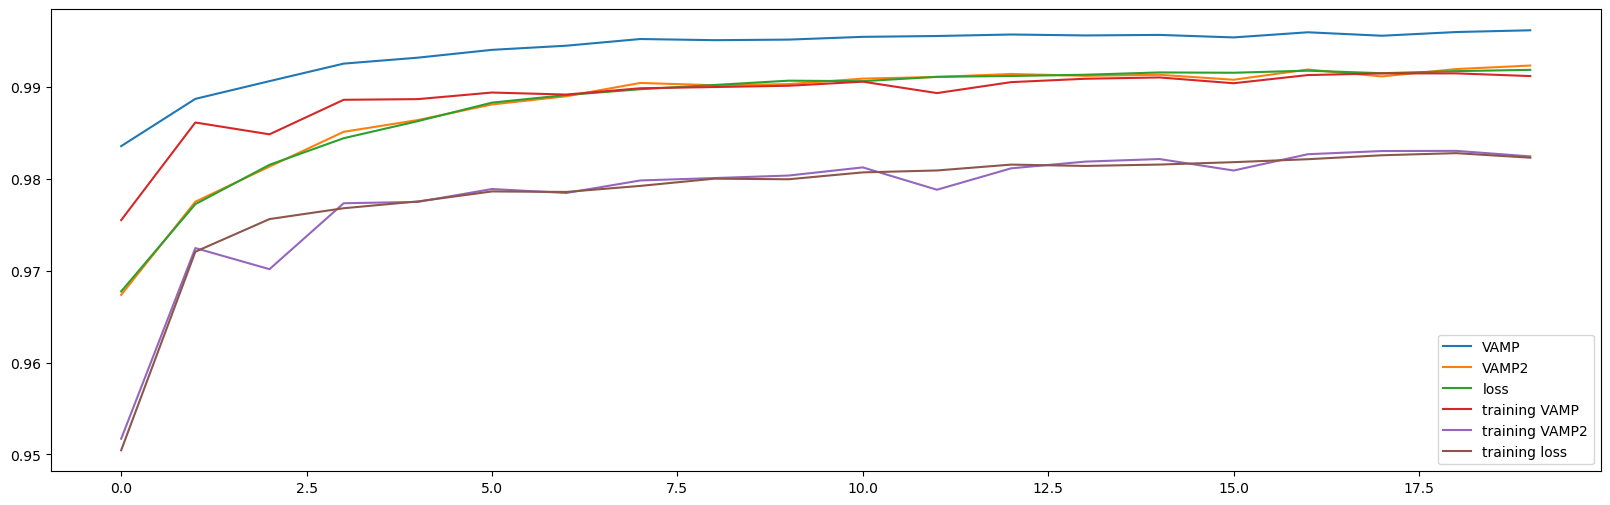

In [82]:
plt.plot(vm1, label = 'VAMP')
plt.plot(vm2, label = 'VAMP2')
plt.plot(-vm3, label = 'loss')
plt.plot(tm1, label = 'training VAMP')
plt.plot(tm2, label = 'training VAMP2')
plt.plot(-tm3, label = 'training loss')
plt.legend()
plt.savefig("losses.png")
plt.show()

# Model predictions

OMP: Info #250: KMP_AFFINITY: pid 780361 tid 780477 thread 1 bound to OS proc set 1
OMP: Info #250: KMP_AFFINITY: pid 780361 tid 780476 thread 2 bound to OS proc set 2
OMP: Info #250: KMP_AFFINITY: pid 780361 tid 780535 thread 3 bound to OS proc set 3
OMP: Info #250: KMP_AFFINITY: pid 780361 tid 780536 thread 4 bound to OS proc set 4
OMP: Info #250: KMP_AFFINITY: pid 780361 tid 780538 thread 6 bound to OS proc set 6
OMP: Info #250: KMP_AFFINITY: pid 780361 tid 780539 thread 7 bound to OS proc set 7
OMP: Info #250: KMP_AFFINITY: pid 780361 tid 780541 thread 9 bound to OS proc set 1
OMP: Info #250: KMP_AFFINITY: pid 780361 tid 780540 thread 8 bound to OS proc set 0
OMP: Info #250: KMP_AFFINITY: pid 780361 tid 780537 thread 5 bound to OS proc set 5
OMP: Info #250: KMP_AFFINITY: pid 780361 tid 780545 thread 13 bound to OS proc set 5
OMP: Info #250: KMP_AFFINITY: pid 780361 tid 780544 thread 12 bound to OS proc set 4
OMP: Info #250: KMP_AFFINITY: pid 780361 tid 780542 thread 10 bound to OS 

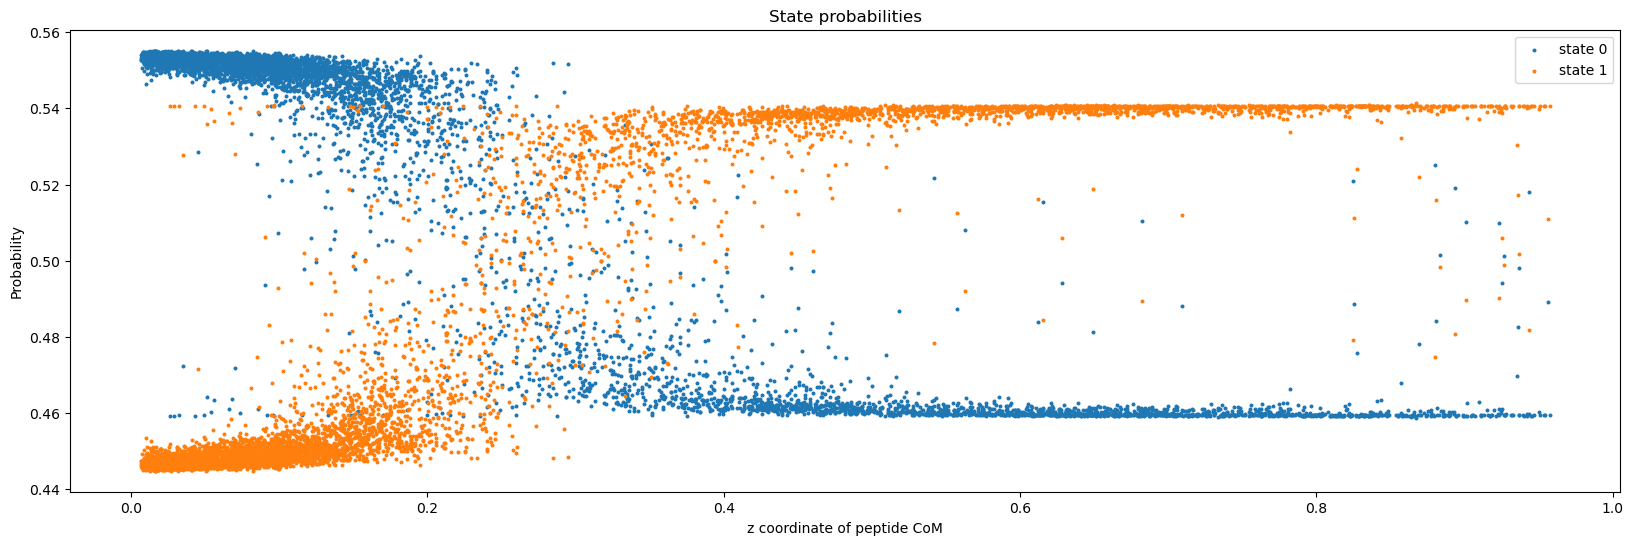

In [16]:
temp = model.predict([traj_ord, traj_ord_lag], batch_size=np.shape(X1_vali)[0])
    
x_a = temp[:, :output_size]
average_peptide_z = (np.average(np.abs(peptide_coords[..., 2]), axis = 1))
n_frames = np.min([x_a.shape[0], average_peptide_z.shape[0]])
time = np.arange(n_frames)

plt.clf()
for i in range(output_size):
    plt.scatter(average_peptide_z[:n_frames], x_a[:n_frames, i], label= 'state '+str(i), s=3.5)
plt.title('State probabilities')
plt.xlabel("z coordinate of peptide CoM")
plt.ylabel("Probability")

plt.legend()
plt.show()

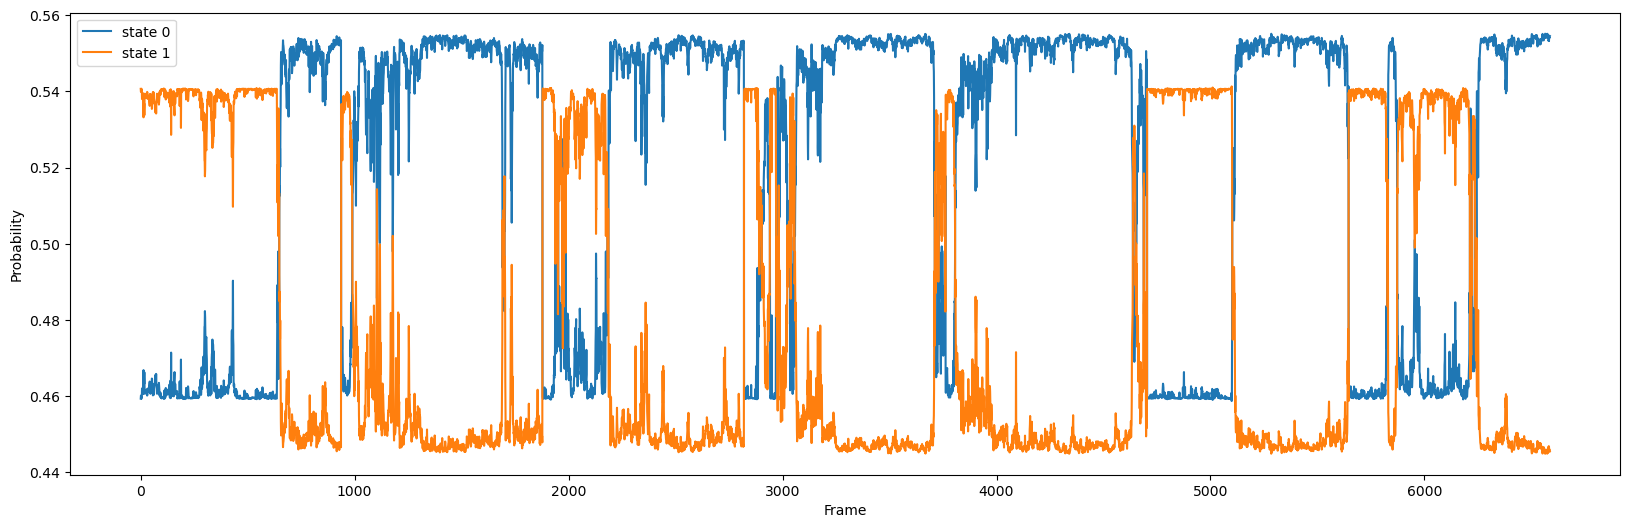

In [86]:
plt.plot(x_a[:, 0], label="state 0")
plt.plot(x_a[:, 1], label="state 1")
plt.legend()
plt.xlabel("Frame")
plt.ylabel("Probability");

# Brute-force estimation of real minimum peptide-condensate distance

In [75]:
def print_progress(current, total):
    progress = current / total * 100
    print(f"Progress: {progress:.2f}%", end="\r")

step = 1000

def minimum_distance_to_condensate(condensate, peptide):
    snapshots = peptide.shape[0]
    step = 1  # Modify step value as needed
    frames = snapshots * 7 - 2

    peptide_expanded = np.expand_dims(peptide, axis=1)  # Expand dimensions for broadcasting

    minimum_distance_list = []
    for frame in range(frames):
        print_progress(frame, frames)

        condensate_points = condensate[frame % snapshots][::step]
        distances = np.linalg.norm(condensate_points[:, np.newaxis] - peptide_expanded[frame], axis=2)
        minimum_distance = np.min(distances)

        minimum_distance_list.append(minimum_distance)

    return np.array(minimum_distance_list)
        
cond = raw_coords[:, :-7 * peptide_atoms]
pept = peptide_coords.reshape(peptide_coords.shape[0], peptide_atoms,  3)
min_dist_to_cond = minimum_distance_to_condensate(np.zeros_like(pept), pept)

IndexError: index 6594 is out of bounds for axis 0 with size 6594

# Show correlation between msm probabilities and real minimum distance to condensate 

Correlation: 0.06603011578976345


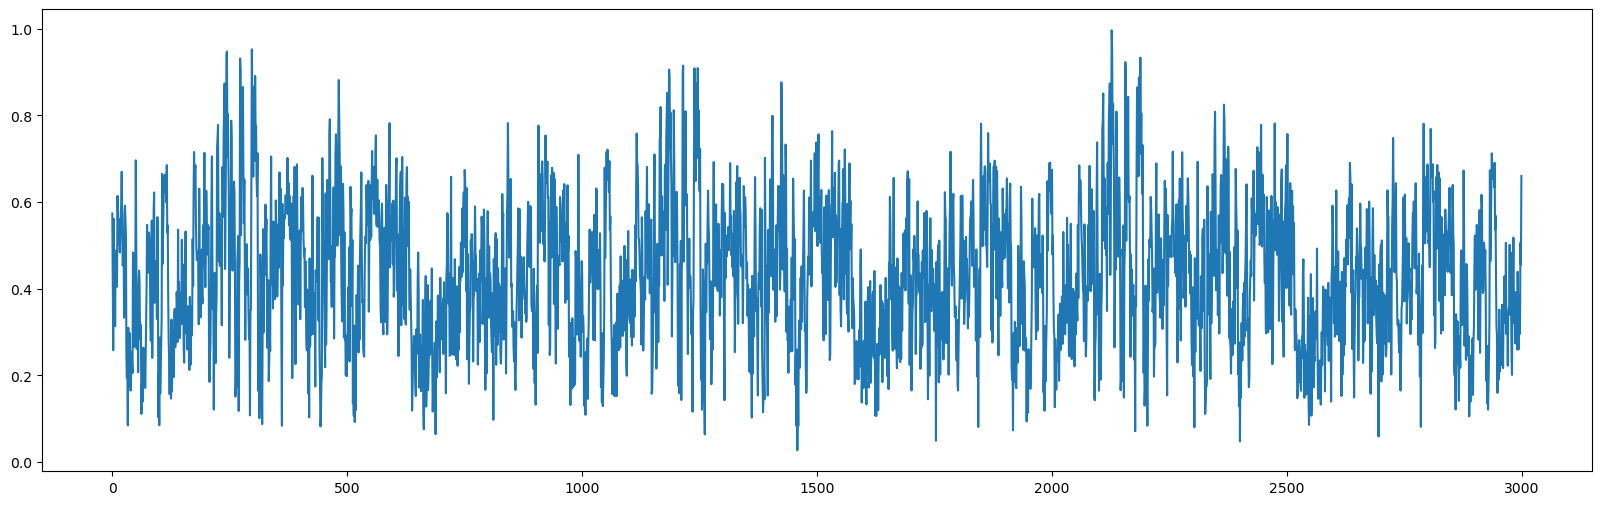

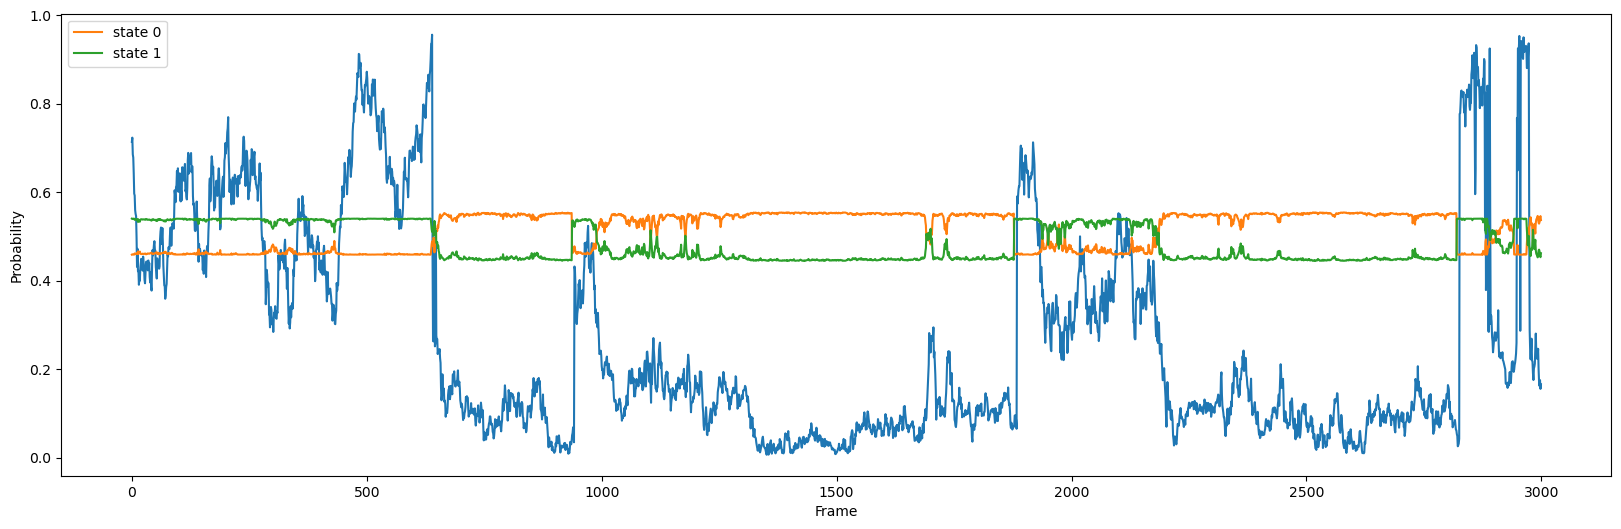

In [69]:
first_n_frames = 3000

n_frames = np.min([x_a.shape[0], average_peptide_z.shape[0]])
correlation1 = np.corrcoef(x_a[:n_frames, 0], min_dist_to_cond[:n_frames])[0, 1]
print("Correlation:", np.abs(correlation))

plt.plot(min_dist_to_cond[:first_n_frames] / max(min_dist_to_cond));
plt.show()

plt.plot(average_peptide_z[:first_n_frames])

plt.plot(x_a[:first_n_frames, 0], label="state 0")
plt.plot(x_a[:first_n_frames, 1], label="state 1")
plt.legend()
plt.xlabel("Frame")
plt.ylabel("Probability");

# Save model weights

In [87]:
best_weights = model.get_weights()
np.save("weights/" + model_name, best_weights, allow_pickle=True)

# Recover the saved model and its training history

In [15]:
#clear_session()

weights_filename = model_name # "best_weights" + "___" #"_posttrained_11_10_2"

model, adam = build_model()

weights = np.load("weights/" + weights_filename + ".npy", allow_pickle=True) #.tolist()
model.set_weights((weights).tolist() )    #from nparray

2023-07-04 04:43:25.782626: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-04 04:43:25.826684: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3000000000 Hz
2023-07-04 04:43:25.827899: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55dbfe831fe0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-07-04 04:43:25.827935: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
OMP: Info #212: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #210: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-7
OMP: Info #156: KMP_AFFINITY

In [ ]:
losses = [
          vamp.loss_VAMP2_autograd,
]

checkpoint_path = "model_checkpoints/"

my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=2)
]

vm1 = np.zeros((len(losses), nb_epoch))
tm1 = np.zeros_like(vm1)
vm2 = np.zeros_like(vm1)
tm2 = np.zeros_like(vm1)
vm3 = np.zeros_like(vm1)
tm3 = np.zeros_like(vm1)
valid_metric = np.zeros_like(vm1)
train_metric = np.zeros_like(vm1)


for l_index, loss_function in enumerate(losses):

    model.compile(optimizer = adam,
                  loss = loss_function,
                  metrics = [
                      vamp.metric_VAMP,
                      vamp.metric_VAMP2,
                             ])

    # Train the model
    print("Started training model.")        
    hist = model.fit([X1_train, X2_train], Y_train ,
                     batch_size=batch_size,
                     epochs= nb_epoch,
                     validation_data=([X1_vali, X2_vali], Y_vali ),
                     verbose=2, callbacks=my_callbacks)


    vm1[l_index] = np.array(hist.history['val_metric_VAMP'])
    tm1[l_index] = np.array(hist.history['metric_VAMP'])


    vm2[l_index] = np.array(hist.history['val_metric_VAMP2'])
    tm2[l_index] = np.array(hist.history['metric_VAMP2'])

    vm3[l_index] = np.array(hist.history['val_loss'])
    tm3[l_index] = np.array(hist.history['loss'])

    valid_metric[l_index] = np.array(hist.history['val_metric_VAMP'])
    train_metric[l_index] = np.array(hist.history['metric_VAMP'])


vm1 = np.reshape(vm1, (-1))
tm1 = np.reshape(tm1, (-1))
vm2 = np.reshape(vm2, (-1))
tm2 = np.reshape(tm2, (-1))
vm3 = np.reshape(vm3, (-1))
tm3 = np.reshape(tm3, (-1))

valid_metric[l_index] = np.reshape(valid_metric, (-1))
train_metric[l_index] = np.reshape(train_metric, (-1))

# Average the score obtained in the last part of the training process
# in order to estabilish which model is better and thus worth saving


score = vm1[-5:].mean()
extra_msg = ''

extra_msg = ' - Highest'
best_weights = model.get_weights()
np.save("weights/best_weights_posttrained_11_10_2", best_weights, allow_pickle=True)
max_vm = score
vm1_max = vm1
tm1_max = tm1
vm2_max = vm2
tm2_max = tm2
vm3_max = vm3
tm3_max = tm3

print('Score: {0:.2f}'.format(score) + extra_msg)

Started training model.
Train on 5928 samples, validate on 659 samples
Epoch 1/3000

Epoch 00001: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
5928/5928 - 2s - loss: -9.9907e-01 - metric_VAMP: 0.9995 - metric_VAMP2: 0.9991 - val_loss: -9.1648e-01 - val_metric_VAMP: 0.9573 - val_metric_VAMP2: 0.9165
Epoch 2/3000

Epoch 00002: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
5928/5928 - 0s - loss: -9.9916e-01 - metric_VAMP: 0.9996 - metric_VAMP2: 0.9992 - val_loss: -9.1659e-01 - val_metric_VAMP: 0.9574 - val_metric_VAMP2: 0.9166
Epoch 3/3000

Epoch 00003: saving model to model_checkpoints/

Consider using a TensorFlow optimizer from `tf.train`.
5928/5928 - 0s - loss: -9.9919e-01 - metric_VAMP: 0.9996 - metric_VAMP2: 0.9992 - val_loss: -9.1660e-01 - val_metric_VAMP: 0.9574 - val_metric_VAMP2: 0.9166
Epoch 4/3000

Epoch 00004: saving model to model_checkpoints/

Consider using a TensorFlow optimizer fro

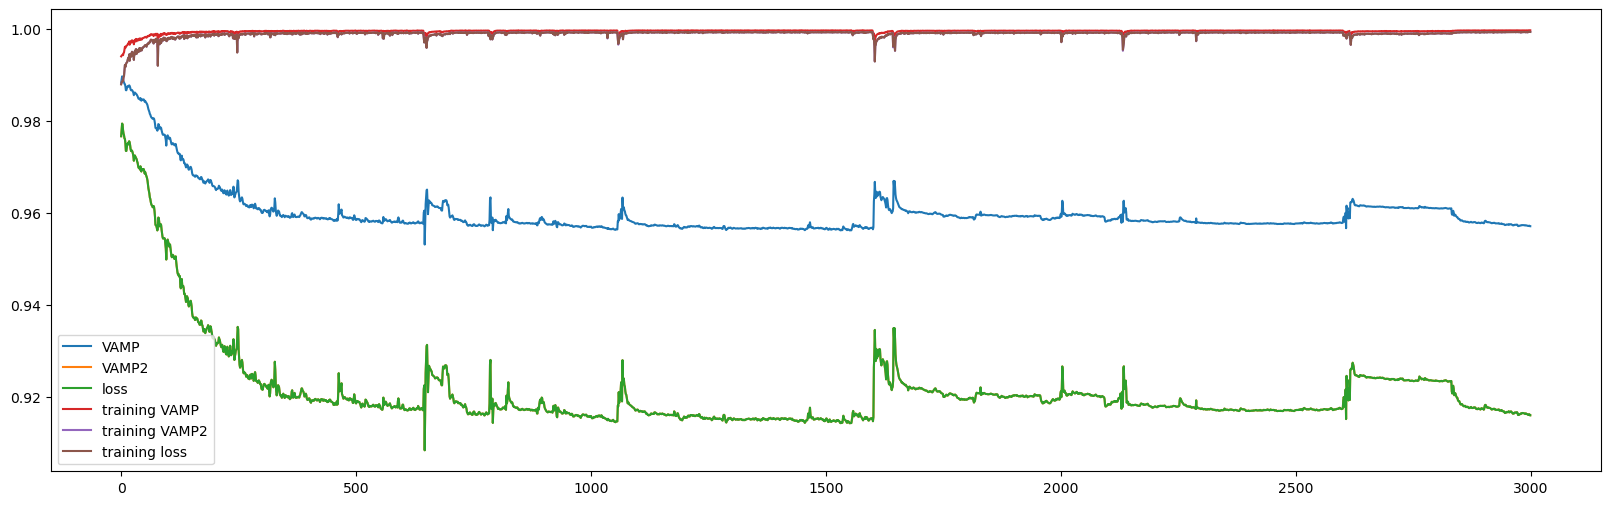

In [122]:
plt.plot(vm1, label = 'VAMP')
plt.plot(vm2, label = 'VAMP2')
plt.plot(-vm3, label = 'loss')
plt.plot(tm1, label = 'training VAMP')
plt.plot(tm2, label = 'training VAMP2')
plt.plot(-tm3, label = 'training loss')
plt.legend()
plt.show()

In [92]:
# Transform the input trajectory using the network
states_prob = x_a #model.predict([traj_ord, traj_ord_lag])[:, :output_size]

# Order the output states based on their population
coor_pred = np.argmax(states_prob, axis = 1)
indexes = [np.where(coor_pred == np.multiply(np.ones_like(coor_pred), n)) for n in range(output_size)]
states_num = [len(i[0]) for i in indexes]
states_order = np.array(states_num).astype('int')[::-1]

states_order = np.argsort(states_num).astype('int')[::-1]
pred_ord = states_prob[:,states_order]

# Visualize the population of the states

States population: [66.84378321 33.15621679]%
[4403, 2184]


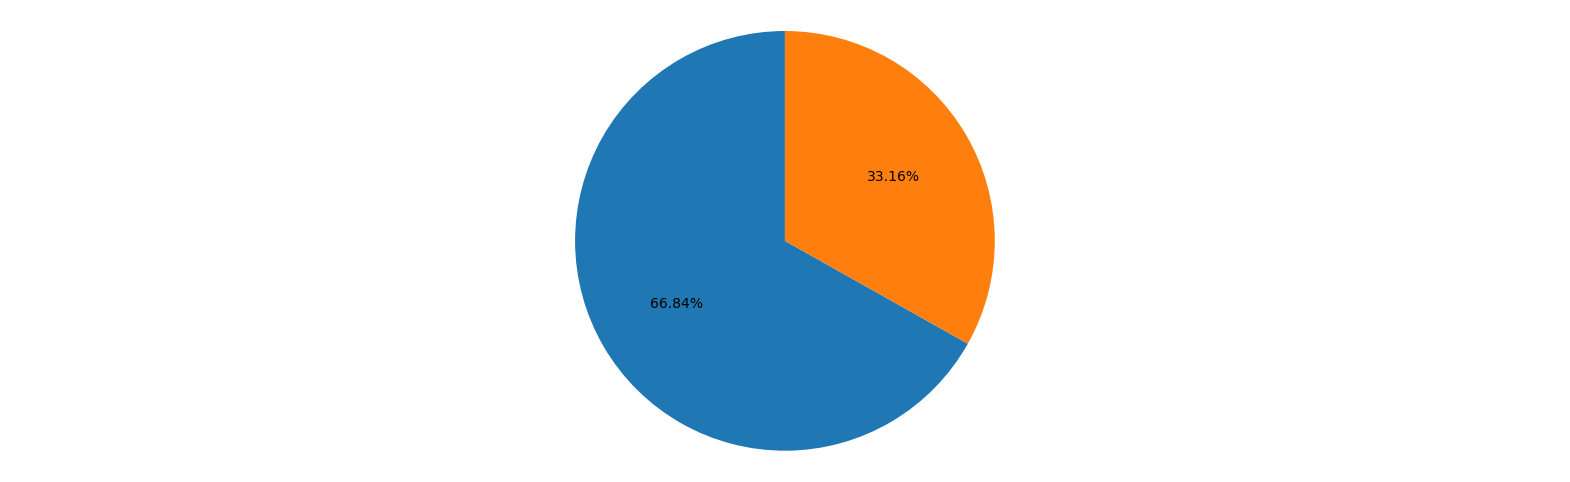

<Figure size 2000x600 with 0 Axes>

In [90]:
def print_states_pie_chart():
    coors = []
    maxi = np.max(states_prob, axis= 1)
    for i in range(output_size):
        coors.append(len(np.where(states_prob[:,i] == maxi)[0]))
        
    fig1, ax1 = plt.subplots()
    ax1.pie(np.array(coors), autopct='%1.2f%%', startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    print('States population: '+str(np.array(coors)/len(maxi)*100)+'%')
    print(coors)
    plt.show()
    plt.savefig("states_population.png")

print_states_pie_chart()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


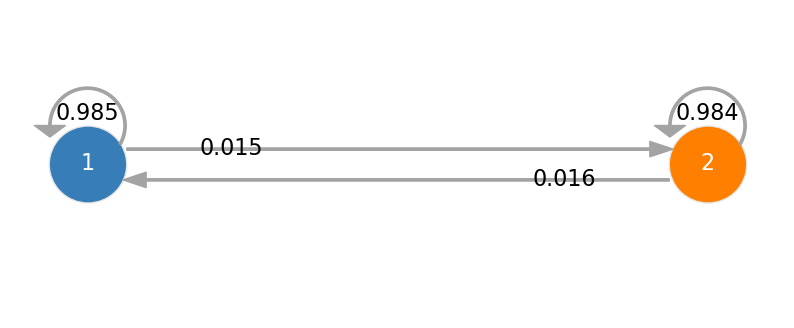

In [93]:
%load_ext autoreload
%autoreload 2

tau_msm = 5

K_smt_nonmeanfree = vamp.estimate_koopman_op(pred_ord, tau_msm)
K_smt_nonmeanfree = np.round(K_smt_nonmeanfree, decimals = 3)
import numpy as np
import matplotlib.pyplot as plt 
# Import the MarkovChain class from markovchain.py
from markovchain import MarkovChain


nodes_facecolor = ['#377eb8', '#ff7f00']
mc = MarkovChain(K_smt_nonmeanfree, ['1', '2'], nodes_facecolor = nodes_facecolor)
mc.draw()

# Markov Model Estimation

# Estimate the implied timescales

In [ ]:
max_tau = 200
lag = np.arange(1, max_tau, 1)
its = vamp.get_its(pred_ord, lag)
vamp.plot_its(its, lag)

# Chapman-Kolmogorov test for the estimated koopman operator

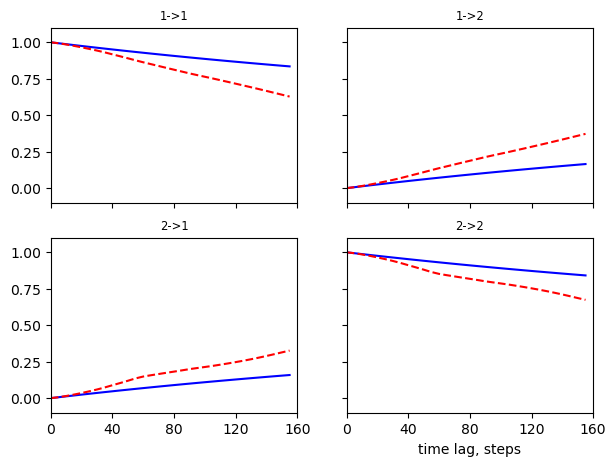

In [35]:
plt.rcParams["figure.figsize"] = (7, 5)

from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

def custom_plot_ck_test(pred, est, n_states, steps, tau):
        '''Plots the result of the Chapman-Kolmogorov test calculated by the function
        'get_ck_test'
        Parameters
        ----------
        pred: numpy array
        est: numpy array
            pred, est are the two arrays returned by the function get_ck_test
        n_states: int
        steps: int
        tau: int
            values used for the Chapman-Kolmogorov test as parameters in the function
            get_ck_test
        '''
        
        fig, ax = plt.subplots(n_states, n_states, sharex=True, sharey=True)
        for index_i in range(n_states):
            for index_j in range(n_states):
                
                ax[index_i][index_j].plot(np.arange(0, steps*tau, tau)# * picoseconds_per_step
                                          ,pred[index_i, index_j], color='b')
                
                ax[index_i][index_j].plot(np.arange(0, steps*tau, tau)# * picoseconds_per_step
                                          ,est[index_i, index_j], color='r', linestyle='--')
                
                ax[index_i][index_j].set_title(str(index_i+1)+ '->' +str(index_j+1),
                                               fontsize='small')
        
        ax[0][0].set_ylim((-0.1,1.1));
        ax[0][0].set_xlim((0, steps*tau));
        
        #ax[0][0].axes.get_xaxis().set_ticks(np.round(np.linspace(0, steps*tau, 5)) * picoseconds_per_step);#(np.round(np.linspace(0, steps*tau, 5)));
        ax[0][0].axes.get_xaxis().set_ticks(np.round(np.linspace(0, steps*tau, 5)));
        
        
        # -------------------------------------------
        
        
        #ax[1][1].axes.set_xlabel("Time lag, ps")
        #ax[1][0].axes.set_xlabel("Time lag, ps")
        
        ax[1][1].axes.set_xlabel("time lag, steps")
        ax[1][1].axes.set_xlabel("time lag, steps")
        
        '''ax2 = ax[0][0].twiny()
        ax2.set_xlabel("x-transformed")
        ax2.set_xlim(0, 60)'''
        #ax2.set_xticks(np.arange(0, steps*tau, tau) * picoseconds_per_step)
        
        plt.show()
        

steps = 2**5 #2**4 or 2**9
predicted, estimated = vamp.get_ck_test(pred_ord, steps, tau_msm)
custom_plot_ck_test(predicted, estimated, output_size, steps, tau_msm)